In [1]:
import numpy as np 
from PIL import Image
import math
import matplotlib.pyplot as plt 

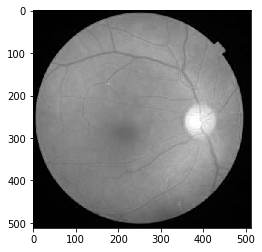

In [2]:
img = Image.open("test.jpg")
img = np.array(img)
# img = 1.0*(img-np.mean(img))/np.std(img)
plt.imshow(img[:,:,0],cmap="gray")
plt.show()

### The padding function ###

In [3]:
def padding(arr,ker_rows,ker_cols,stride):
    row_pad_size = int(math.ceil((arr.shape[0]*(stride[0]-1)+ker_rows-stride[0])/2))  
    col_pad_size = int(math.ceil((arr.shape[1]*(stride[1]-1)+ker_rows-stride[1])/2))
    tmp1 = np.zeros((row_pad_size,arr.shape[1],arr.shape[2]))
    arr = np.vstack((tmp1,arr,tmp1))
    tmp2 = np.zeros((arr.shape[0],col_pad_size,arr.shape[2]))
    arr = np.hstack((tmp2,arr,tmp2))
    return arr

### Q1 (Convolution function)

In [4]:
def conv_function(arr,ker_shape,stride,pad,activation):
    ker_rows = ker_shape[0]
    ker_cols = ker_shape[1]
    ker = np.random.normal(0,1,(ker_rows,ker_cols,arr.shape[2]))
    i=0
    j=0
    k=0
    l=0
    if pad=="True":
        arr = padding(arr,ker_rows,ker_cols,stride)
    new_shape = (int((arr.shape[0]-ker_rows)/stride[0])+1,int((arr.shape[1]-ker_cols)/stride[1])+1,1)
    out = np.zeros(new_shape)
    bias = np.random.normal(0,1,new_shape)
    while(1):
        if ker_rows+i > arr.shape[0]:
            break
        else:
            while(1):
                if ker_cols+j > arr.shape[1]: ### we reached the end of set corresponding to the current row
                    j=0
                    l=0
                    i=i+stride[0]
                    k=k+1
                    break
                else:
                    temp = arr[i:ker_rows+i,j:ker_cols+j,:]
                    out[k][l][0] = np.sum(temp*ker) + bias[k][l][0]
                    if activation == "relu":
                        out[k][l][0] = max(0,out[k][l][0])
                    elif activation == "tanh":
                        out[k][l][0] = np.tanh(out[k][l][0])
                    elif activation == "sigmoid":
                        out[k][l][0] = 1.0/(1+np.exp(-out[k][l][0]))
                    j=j+stride[1]
                    l=l+1
    return out,ker

### Q2 (The pooling function)

In [5]:
def pool(arr,ker_shape,stride,pool_function):
    ker_rows = ker_shape[0]
    ker_cols = ker_shape[1]
    i=0
    j=0
    k=0
    l=0
    new_shape = (int((arr.shape[0]-ker_rows)/stride[0])+1,int((arr.shape[1]-ker_cols)/stride[1])+1)
    out = np.zeros(new_shape)
    while(1):
        if ker_rows+i > arr.shape[0]:
            break
        else:
            while(1):
                if ker_cols+j > arr.shape[1]: ### we reached the end of set corresponding to the current row
                    j=0
                    l=0
                    i=i+stride[0]
                    k=k+1
                    break
                else:
                    temp = arr[i:ker_rows+i,j:ker_cols+j]
                    if pool_function == "average":
                        out[k][l] = np.mean(temp)
                    elif pool_function == "max":
                        out[k][l] = np.max(temp)
                    j=j+stride[1]
                    l=l+1
    return out

### Q3 (Convolution layer function)

In [6]:
def conv_volume(arr,ker_shape,stride,pad,activation,depth):
    temp1 = []
    params = []
    i=0
    while(i<depth):
        temp,weights = conv_function(arr,ker_shape,stride,pad,activation)
        params.append(weights)
        temp1.append(temp)
        i=i+1
    params = np.array(params)
    temp1 = np.array(temp1)
    shape = temp1.shape
    temp1 = temp1.reshape(shape[0],shape[1],shape[2])
    output_volume = np.zeros((shape[1],shape[2],shape[0]))
    for i in range(depth):
        output_volume[:,:,i] = temp1[i,:,:]
    return output_volume,params

### Q4 (Pooling layer function)

In [7]:
def pool_volume(arr,ker_shape,stride,pool_function,depth):
    temp1 = []
    i=0
    while(i<depth):
        temp = pool(arr[:,:,i],ker_shape,stride,pool_function)
        temp1.append(temp)
        i=i+1
    temp1 = np.array(temp1)
    shape = temp1.shape
    temp1 = temp1.reshape(shape[0],shape[1],shape[2])
    output_volume = np.zeros((shape[1],shape[2],shape[0]))
    for i in range(depth):
        output_volume[:,:,i] = temp1[i,:,:]
    return output_volume

### Q5 (Composition of convolution layers)

In [8]:
def composition_conv(arr,param_dict):
    ## param_dict consists of all required parameters of a composition of conv layers
    ## Every conv layer will be followed by a pooling layer
    ## activation maps after every pooling layer are plotted
    weights_dict = {}
    temp = arr
    for i in range(len(param_dict["depth"])):
        print("Shape before convolution and pooling: " + str(temp.shape))
        temp,weights = conv_volume(temp,param_dict["ker_shape"][i],param_dict["stride"][i],
                        param_dict["pad"][i],
                        param_dict["activation"][i],param_dict["depth"][i])
        temp = pool_volume(temp,(2,2),(2,2),param_dict["pooling"][i],param_dict["depth"][i])
        weights_dict[str(i+1)] = weights
        print("Shape after convolution and pooling: " + str(temp.shape))
        for j in range(temp.shape[2]):
            print("Activation map " + str(j+1) + " of " + "layer " + str(i+1))
            plt.imshow(temp[:,:,j],cmap="gray")
            plt.show()
    return temp,weights_dict

### Q6 (Unravel function)

In [9]:
def unravel_fun(arr,dim_fcn):
    flatten = arr.reshape(-1,1)
    print(flatten.shape)
    weights = np.random.normal(0,1,(dim_fcn,len(flatten)))
    output = np.matmul(weights,flatten)
    return output

### Q7(MLP layer)

In [10]:
### helper function for mlp, takes number of nodes and activation as input, returns the output of one fcn layer
def fcn_layer(arr,num_nodes,activation):
    weights = np.random.normal(0,1,(num_nodes,len(arr)))
    bias = np.random.normal(0,1,(num_nodes,1))
    output = np.matmul(weights,arr) + bias
    if activation == "relu":
        output[output<0] = 0
    elif activation == "sigmoid":
        output = 1/(1+np.exp(-output))
    elif activation == "tanh":
        ouput = np.tanh(output)
    return output

### param dict consists of number of nodes, activation
def mlp(arr,param_dict):
    temp = arr
    for i in range(0,len(param_dict["num_nodes"])):
        temp = fcn_layer(temp,param_dict["num_nodes"][i],param_dict["activation"][i])
    return temp

### The softmax activation for the final layer

In [11]:
def softmax(arr):
    return np.exp(arr)/(np.sum(np.exp(arr),axis=0))

In [12]:
### Any of these parameters can be changed. This is the dictionary which will be passed to the composition of conv layers
### Increase number of elements in the list corresponding to "depth" to increase number of layers
### Make sure that power(2,number of layers) does not exceed input_dimension 
### also when new element is appended to list, make sure that the activation 
### and pooling type are specified(just add those elements to the respective lists)
### available activations are relu,tanh,sigmoid and available pooling functions are max,average
conv_dict = {"ker_shape":[],"depth":[8,8,4,4],"stride":[],"pad":[],
             "activation":["relu","relu","relu","relu"],"pooling":["max","max","max","max"]}

for i in range(len(conv_dict["depth"])):
    conv_dict["ker_shape"].append((3,3)) ## the kernel shape
    conv_dict["stride"].append((1,1)) ## the stride
    conv_dict["pad"].append("True") ## padding
### the parameter dictionary of the MLP, here also repeat the same to increase number of layers
### add a new element in num_nodes and also specify the activation for that layer
mlp_dict = {"num_nodes":[40,20,10],"activation":["relu","relu","relu"]}

### The combination of conv, unravel and mlp

Shape before convolution and pooling: (512, 512, 3)
Shape after convolution and pooling: (256, 256, 8)
Activation map 1 of layer 1


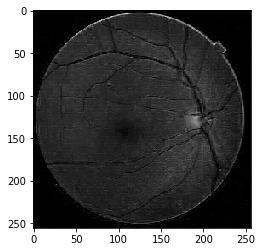

Activation map 2 of layer 1


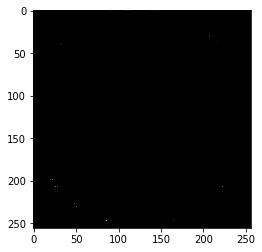

Activation map 3 of layer 1


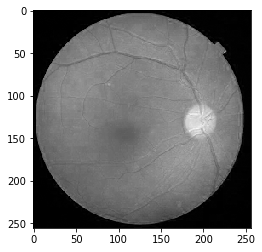

Activation map 4 of layer 1


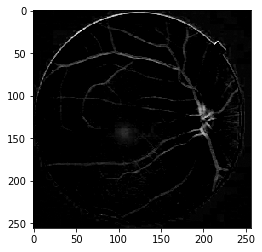

Activation map 5 of layer 1


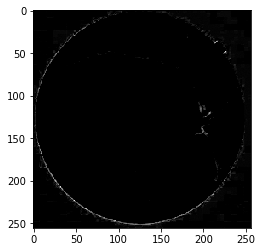

Activation map 6 of layer 1


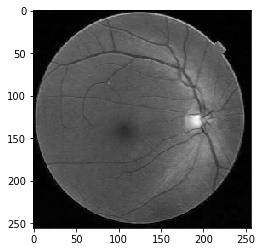

Activation map 7 of layer 1


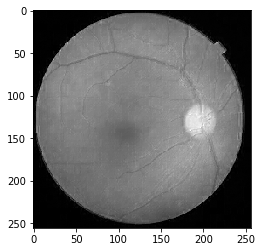

Activation map 8 of layer 1


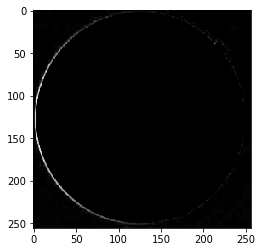

Shape before convolution and pooling: (256, 256, 8)
Shape after convolution and pooling: (128, 128, 8)
Activation map 1 of layer 2


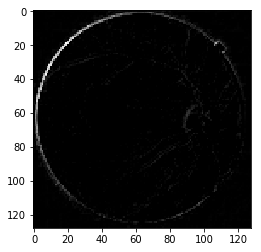

Activation map 2 of layer 2


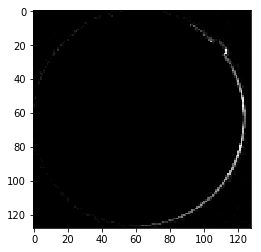

Activation map 3 of layer 2


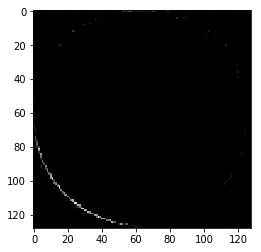

Activation map 4 of layer 2


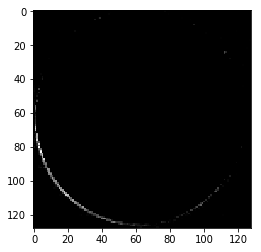

Activation map 5 of layer 2


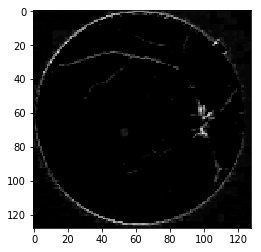

Activation map 6 of layer 2


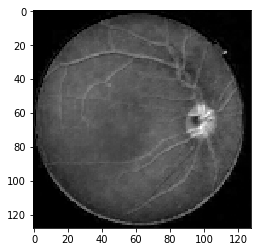

Activation map 7 of layer 2


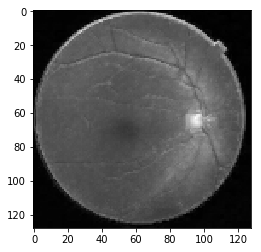

Activation map 8 of layer 2


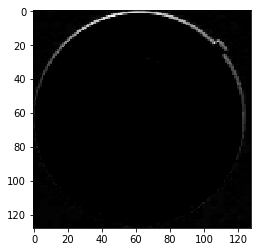

Shape before convolution and pooling: (128, 128, 8)
Shape after convolution and pooling: (64, 64, 4)
Activation map 1 of layer 3


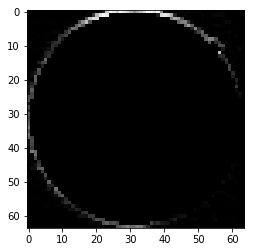

Activation map 2 of layer 3


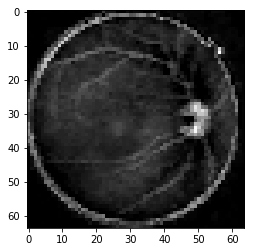

Activation map 3 of layer 3


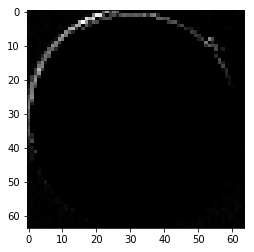

Activation map 4 of layer 3


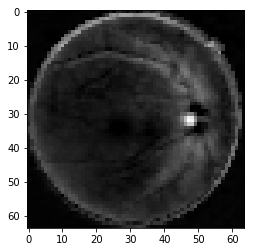

Shape before convolution and pooling: (64, 64, 4)
Shape after convolution and pooling: (32, 32, 4)
Activation map 1 of layer 4


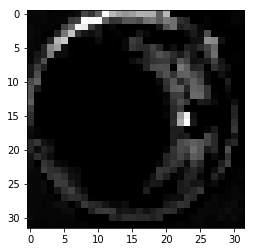

Activation map 2 of layer 4


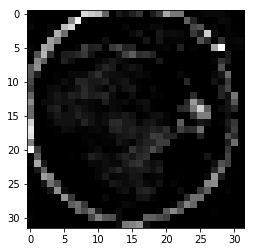

Activation map 3 of layer 4


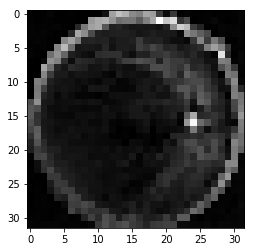

Activation map 4 of layer 4


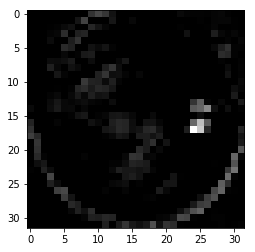

(32, 32, 4)
(4096, 1)
(40, 1)
Output without softmax: [[       0.        ]
 [ 4311908.50033243]
 [       0.        ]
 [40538407.88335881]
 [       0.        ]
 [34088517.14226265]
 [       0.        ]
 [       0.        ]
 [16990810.29017058]
 [27674595.26068024]]
(10, 1)
Output with softmax: [[0.0682652 ]
 [0.07592652]
 [0.0682652 ]
 [0.18556404]
 [0.0682652 ]
 [0.15826873]
 [0.0682652 ]
 [0.0682652 ]
 [0.10380652]
 [0.13510821]]


In [13]:
### the composition of conv layers
conv_out,weights_dict = composition_conv(img,conv_dict)
print(conv_out.shape)
### the unravel function
unravel = unravel_fun(conv_out,40)
print(unravel.shape)
### the output of mlp
out_mlp = mlp(unravel,mlp_dict)
print("Output without softmax: " + str(out_mlp))
print(out_mlp.shape)
### scaling so that softmax does not get overflowed. Scaling by same factor does not effect softmax output too.
out_mlp = out_mlp/np.max(out_mlp)
### softmax activation
out = softmax(out_mlp)
print("Output with softmax: " + str(out))

In [14]:
### the filter weights are of the dimension (current_layer depth,kernel_rows,kernel_cols,previous_layer depth)
### the keys represent the layer number
for key in weights_dict.keys():
    print("Filter_weights of layer " + key + ": " )
    print(weights_dict[key].shape)
    print(weights_dict[key])
    print()

Filter_weights of layer 4: 
(4, 3, 3, 4)
[[[[ 1.46573161e+00 -4.18168030e-01  2.00052937e+00  3.13622394e-01]
   [-6.41620621e-01 -1.64560362e+00  1.81995865e+00 -1.25926934e+00]
   [ 4.36123294e-01 -1.96340105e-01  1.49946837e+00  9.78643033e-01]]

  [[ 2.15630669e-01 -9.40854124e-01 -8.71769235e-01 -1.31195130e+00]
   [ 8.38080054e-01 -1.56977480e+00 -2.41453879e-01  6.02910172e-01]
   [-1.40940434e-01 -9.76997160e-01 -1.39075945e+00  8.38630664e-01]]

  [[-9.59386958e-02 -1.02837572e-01 -1.15253897e-01 -3.56753526e-01]
   [-1.24090572e+00 -1.13126281e+00 -4.17405785e-01  1.03858394e+00]
   [ 2.27062105e-01  7.22064262e-01  1.23686418e+00  9.38922242e-01]]]


 [[[-6.00452239e-01  7.97230680e-02  6.59667745e-01 -5.57755981e-01]
   [ 6.25152458e-01  3.62225701e-01 -7.32123818e-01  3.70185454e-02]
   [ 2.06672106e-01 -1.76511528e+00 -9.49660637e-01  1.23064331e-01]]

  [[-8.25879882e-02  1.43645348e-01 -5.84810923e-01 -7.69602173e-01]
   [-1.54090102e+00 -2.44876305e-01  4.21346594e-01 